In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import matplotlib
from matplotlib.gridspec import GridSpec
import uuid
import json
import seaborn as sns
import requests
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

matplotlib.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg' 

In [2]:
with open('../data/meso-sah-event-2023.pkl', 'rb') as f:
    sah = pickle.load(f)

with open('../data/meso-xph-event-2023.pkl', 'rb') as f:
    xph = pickle.load(f)

In [3]:
sah_meta = pd.read_csv('../data/meso-sah-metadata-2023.csv', dtype={'sex': str, 'age': int, 'height': float, 'weight': float, 'op_level': str, 'emergency': str, 'anesthesia_method': str})
sah_meta['asa_level'] = sah_meta['asa_level'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
sah_meta.head()

case_idx sex  age  height  weight  \
0  90b82ee0-01ca-4e18-9746-46f10252052b   1   60   162.0    70.0   
1  4dca56fd-27ec-495a-a200-056526e3c642   1   29   171.0    66.0   
2  24c490ee-b956-4af9-8a41-a26a60eeeec2   1   57   172.0    55.0   
3  a452aed8-ee9a-4606-8c68-09b9950148b1   1   59   173.0    68.0   
4  38a3979c-e22d-4932-acfc-a6c40a8e28c3   0   50   160.0    58.0   

  diagnosis_ICD10 op_level emergency main_procedure_ICD9  \
0         K60.303        2         0             49.7301   
1         C20.x00        4         0             48.6302   
2         C20.x00        4         0             48.6302   
3         C18.600        4         0         17.3900x002   
4         Z43.200        2         0             46.5101   

                        exec_department anesthesia_method asa_level  
0  b67de430-978e-459f-a599-9d825c8fc802                 8         2  
1  5f75ad41-1a86-41ab-9846-d1bc95134486                 1         1  
2  fd3b929b-7c70-4ea2-9faf-1b3009cd93e9                 1         2  
3  4712944a-131c-4936-a2b9-29de5dcf7b13                 1         2  
4  fd3b929b-7c70-4ea2-9faf-1b3009cd93e9                 7         2

In [4]:
xph_meta = pd.read_csv('../data/meso-xph-metadata-2023.csv', dtype={'sex': str, 'age': int, 'height': float, 'weight': float, 'op_level': str, 'emergency': str, 'anesthesia_method': str})
xph_meta['asa_level'] = xph_meta['asa_level'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
xph_meta.head()

case_idx sex  age  height  weight  \
0  cf8b8e66-90f2-46c2-bab2-702cecba06cf   0   37   153.0    59.0   
1  6cde2d2e-e4e3-4d03-b609-0dcc95feebdb   1   53   162.0    58.0   
2  5cde578f-c628-4e9c-bc22-77cc89d2fdbc   0   23   150.0    40.0   
3  b7b297b6-6e9e-42cb-bf0d-5ba1cde50009   0   41   160.0    58.0   
4  031da36e-600d-42c6-b38f-c7f0ee084bc5   0   20   160.0    78.0   

  diagnosis_ICD10 op_level emergency main_procedure_ICD9  \
0         O02.100      1.0         0             69.5901   
1         S72.000      4.0         0             81.5201   
2         N75.100      3.0         0         71.2900x002   
3         N87.101      3.0         0             67.3202   
4         O04.401      3.0         0         68.1200x001   

                        exec_department anesthesia_method asa_level  
0  87dcf9e3-7e70-4980-966e-3dcc816a9636                 5         1  
1  cd20c810-4662-4a0e-80c2-8c079817c84a                10         2  
2  b0ab2964-1396-4195-b092-aa1cede09c42                 5         1  
3  b0ab2964-1396-4195-b092-aa1cede09c42                 5         1  
4  b0ab2964-1396-4195-b092-aa1cede09c42                 5         1

In [ ]:
# the format of the input like:
# {
#     "dim_process": 7, # the number of different events
#     "idx_to_event": {'0': 'PA-In','1': 'AS','2': 'PA-Out','3': 'OR-In','4': 'OS','5': 'OE','6': 'AE','7': 'OR-Out','8': 'PACU-In','9': 'PACU-Out'}, # for SAH
#     "idx_to_event": {0: 'OR-In',1: 'AS',2: 'OS',3: 'OE',4: 'OR-Out',5: 'PACU-In',6: 'PACU-Out'}, # for XPH
#     "idx_to_room": {0: 'OR-1',1: 'OR-2',2: 'OR-3',3: 'OR-5',4: 'OR-6',5: 'OR-7',6: 'OR-8',7: 'OR-9',8: 'OR-10',9: 'PACU'},
#     "idx_to_date": {0: '2023-01-01', 1: '2023-01-02', ...},
#     "data": [
#         {
#             "case_id": "XXXX-XXXX-XXXX-XXXX", # unique identifier for each surgery case 
#             'event_date': '2023-01-01',
#             'patient': 'XXXX-XXXX-XXXX-XXXX', # unique identifier for each patient
#             "stream": [
#               {'event_type': 0, 'event_loc': 4, 'timestamp': '2023-01-01 09:50:00', 'surgeon': ['XXXX-XXXX-XXXX-XXXX'], 'anesthetist': ['XXXX-XXXX-XXXX-XXXX'], 'nurse': ['XXXX-XXXX-XXXX-XXXX']},
#               ...
#             ],
#         }
#         ...
#     ]
# }

In [30]:
# load Chinese holidays for 2023 with compensatory leave
holiday_cn_url = 'https://raw.githubusercontent.com/NateScarlet/holiday-cn/master/{}.json'
holiday_cn = requests.get(holiday_cn_url.format(2023), timeout=10)
holiday_cn_df = pd.DataFrame(holiday_cn.json()['days'])
date_off = holiday_cn_df[ holiday_cn_df['isOffDay'] == True ]['date'].tolist() # holidays
date_on = holiday_cn_df[ holiday_cn_df['isOffDay'] == False ]['date'].tolist() # weekends but taken as working days
holiday_cn_df.head()

name        date  isOffDay
0   元旦  2022-12-31      True
1   元旦  2023-01-01      True
2   元旦  2023-01-02      True
3   春节  2023-01-21      True
4   春节  2023-01-22      True

In [31]:
data1 = sah['data']
data2 = xph['data']
dates_ids1 = [[datetime.strptime(case['event_date'], '%Y-%m-%d'), case['case_id']] for case in data1]
dates_ids2 = [[datetime.strptime(case['event_date'], '%Y-%m-%d'), case['case_id']] for case in data2]
df1 = pd.DataFrame(dates_ids1, columns=['date', 'case_idx'])
df2 = pd.DataFrame(dates_ids2, columns=['date', 'case_idx'])
df1['count'] = 1
df2['count'] = 1
# add emergency column to the dataframes from metadata
df1 = df1.merge(sah_meta[['case_idx', 'emergency']], on='case_idx', how='left')
df2 = df2.merge(xph_meta[['case_idx', 'emergency']], on='case_idx', how='left')
df1_all = df1.groupby('date').count().reset_index()
df2_all = df2.groupby('date').count().reset_index()
# add missing dates to the dataframes to fill in the gaps
df1_all = df1_all.set_index('date').reindex(pd.date_range(start=df1_all['date'].min(), end=df1_all['date'].max()), fill_value=0).reset_index()
df2_all = df2_all.set_index('date').reindex(pd.date_range(start=df2_all['date'].min(), end=df2_all['date'].max()), fill_value=0).reset_index()
df1_all.rename(columns={'index': 'date'}, inplace=True)
df2_all.rename(columns={'index': 'date'}, inplace=True)

df1_type = df1.groupby(['date', 'emergency']).count().reset_index()
df2_type = df2.groupby(['date', 'emergency']).count().reset_index()
# add missing date, emergency to the dataframes to fill in the gaps
df1_type = df1_type.set_index(['date', 'emergency']).reindex(pd.MultiIndex.from_product([pd.date_range(start=df1_type['date'].min(), end=df1_type['date'].max()), ['0', '1']], names=['date', 'emergency']), fill_value=0).reset_index()
df2_type = df2_type.set_index(['date', 'emergency']).reindex(pd.MultiIndex.from_product([pd.date_range(start=df2_type['date'].min(), end=df2_type['date'].max()), ['0', '1']], names=['date', 'emergency']), fill_value=0).reset_index()

df1_type['weekday'] = df1_type['date'].map(get_weekday)
df1_type_wd = df1_type.groupby(['weekday', 'emergency']).sum(['count']).reset_index()
df1_type_wd.head()

weekday emergency  case_idx  count
0        0         0      2926   2926
1        0         1      1380   1380
2        1         0      3084   3084
3        1         1      1416   1416
4        2         0      3213   3213

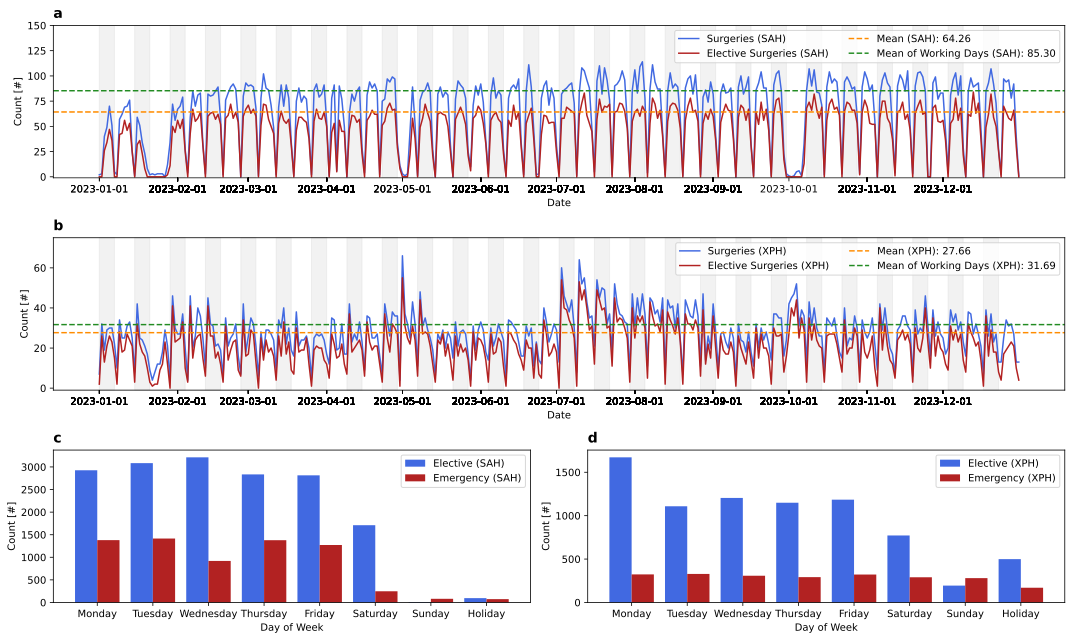

In [33]:
# plot the number of surgeries per day for the input data to show the weekly periodicity 
data1 = sah['data']
data2 = xph['data']
dates_ids1 = [[datetime.strptime(case['event_date'], '%Y-%m-%d'), case['case_id']] for case in data1]
dates_ids2 = [[datetime.strptime(case['event_date'], '%Y-%m-%d'), case['case_id']] for case in data2]
df1 = pd.DataFrame(dates_ids1, columns=['date', 'case_idx'])
df2 = pd.DataFrame(dates_ids2, columns=['date', 'case_idx'])
df1['count'] = 1
df2['count'] = 1
# add emergency column to the dataframes from metadata
df1 = df1.merge(sah_meta[['case_idx', 'emergency']], on='case_idx', how='left')
df2 = df2.merge(xph_meta[['case_idx', 'emergency']], on='case_idx', how='left')
df1_all = df1.groupby('date').count().reset_index()
df2_all = df2.groupby('date').count().reset_index()
# add missing dates to the dataframes to fill in the gaps
df1_all = df1_all.set_index('date').reindex(pd.date_range(start=df1_all['date'].min(), end=df1_all['date'].max()), fill_value=0).reset_index()
df2_all = df2_all.set_index('date').reindex(pd.date_range(start=df2_all['date'].min(), end=df2_all['date'].max()), fill_value=0).reset_index()
df1_all.rename(columns={'index': 'date'}, inplace=True)
df2_all.rename(columns={'index': 'date'}, inplace=True)

df1_type = df1.groupby(['date', 'emergency']).count().reset_index()
df2_type = df2.groupby(['date', 'emergency']).count().reset_index()
# add missing date, emergency to the dataframes to fill in the gaps
df1_type = df1_type.set_index(['date', 'emergency']).reindex(pd.MultiIndex.from_product([pd.date_range(start=df1_type['date'].min(), end=df1_type['date'].max()), ['0', '1']], names=['date', 'emergency']), fill_value=0).reset_index()
df2_type = df2_type.set_index(['date', 'emergency']).reindex(pd.MultiIndex.from_product([pd.date_range(start=df2_type['date'].min(), end=df2_type['date'].max()), ['0', '1']], names=['date', 'emergency']), fill_value=0).reset_index()

fig = plt.figure(figsize=(15, 9), dpi=300)
gs = GridSpec(3, 2, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[0, :2]))  # spans both columns in the first row
ax.append(fig.add_subplot(gs[1, :2]))  # spans both columns in the second row
ax.append(fig.add_subplot(gs[2, 0]))   # bottom row, first column
ax.append(fig.add_subplot(gs[2, 1]))   # bottom row, second column

# draw labels for the subplots
for i, a in enumerate(ax):
    a.text(0, 1.05, chr(97+i), transform=a.transAxes, fontsize=14, weight='bold')

# plot the number of surgeries per day for each hospital
ax[0].plot(df1_all['date'], df1_all['count'], color='royalblue', label='Surgeries (SAH)')
ax[1].plot(df2_all['date'], df2_all['count'], color='royalblue', label='Surgeries (XPH)')
# plot the number of surgeries per day for each hospital with non-emergency (=0, elective) cases
ax[0].plot(df1_type[df1_type['emergency'] == '0']['date'], df1_type[df1_type['emergency'] == '0']['count'], color='firebrick', label='Elective Surgeries (SAH)')
ax[1].plot(df2_type[df2_type['emergency'] == '0']['date'], df2_type[df2_type['emergency'] == '0']['count'], color='firebrick', label='Elective Surgeries (XPH)')

# draw rectangles for every week about in transparent gray
for i in range(0, len(df1_all) // 7, 2):
    ax[0].axvspan(df1_all['date'].iloc[i * 7], df1_all['date'].iloc[i * 7 + 6], color='gray', alpha=0.1)
for i in range(0, len(df2_all) // 7, 2):
    ax[1].axvspan(df2_all['date'].iloc[i * 7], df2_all['date'].iloc[i * 7 + 6], color='gray', alpha=0.1)
# draw a mean line of the average number of surgeries per day
mean_count = df1_all['count'].mean()
ax[0].axhline(mean_count, color='darkorange', linestyle='--', label=f'Mean (SAH): {mean_count:.2f}')
mean_count = df2_all['count'].mean()
ax[1].axhline(mean_count, color='darkorange', linestyle='--', label=f'Mean (XPH): {mean_count:.2f}')
# draw a mean line of the average number of surgeries per day ignoring the holidays and weekends
def get_weekday(d):
    # 0 = Monday, 1 = Tuesday, 2 = Wednesday, 3 = Thursday, 4 = Friday, 5 = Saturday, 6 = Sunday, 7 = Holiday
    # weekends taken as workdays are marked as Monday 
    if d.strftime('%Y-%m-%d') in date_off:
        return 7  # Holiday
    elif d.weekday() >= 5 and d.strftime('%Y-%m-%d') in date_on:
        return 0  # Weekend but taken as workday (Monday) 
    else:
        return d.weekday() # Weekday (0-4) or normal weekend (5-6)

df1_all['weekday'] = df1_all['date'].map(get_weekday)
mean_count_workdays = df1_all[df1_all['weekday'] < 5]['count'].mean()
ax[0].axhline(mean_count_workdays, color='forestgreen', linestyle='--', label=f'Mean of Working Days (SAH): {mean_count_workdays:.2f}')
ax[0].legend(loc='upper right', ncols=2)
ax[0].set_ylim([-1, 150])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Count [#]')
ax[0].set_xticks(df1['date'][df1['date'].dt.day == 1])

df2_all['weekday'] = df2_all['date'].map(get_weekday)
mean_count_workdays = df2_all[df2_all['weekday'] < 5]['count'].mean()
ax[1].axhline(mean_count_workdays, color='forestgreen', linestyle='--', label=f'Mean of Working Days (XPH): {mean_count_workdays:.2f}')
ax[1].legend(loc='upper right', ncols=2)
ax[1].set_ylim([-1, 75])
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Count [#]')
ax[1].set_xticks(df2['date'][df2['date'].dt.day == 1])

# plot the count of surgeries per weekday (Monday to Sunday, plus Holiday) per type of surgery (different bars) of SAH in ax[2] and XPH in ax[3]
df1_type['weekday'] = df1_type['date'].map(get_weekday)
df1_type_wd = df1_type.groupby(['weekday', 'emergency']).sum(['count']).reset_index()
ax[2].bar(df1_type_wd[ df1_type_wd['emergency'] == '0']['weekday'] - 0.2, df1_type_wd[df1_type_wd['emergency'] == '0']['count'], color='royalblue', width=0.4, label='Elective')
ax[2].bar(df1_type_wd[ df1_type_wd['emergency'] == '1']['weekday'] + 0.2, df1_type_wd[df1_type_wd['emergency'] == '1']['count'], color='firebrick', width=0.4, label='Emergency')
ax[2].set_xticks(range(8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Holiday'])
ax[2].legend(['Elective (SAH)', 'Emergency (SAH)'], loc='upper right')
ax[2].set_xlabel('Day of Week')
ax[2].set_ylabel('Count [#]')

df2_type['weekday'] = df2_type['date'].map(get_weekday)
df2_type_wd = df2_type.groupby(['weekday', 'emergency']).sum(['count']).reset_index()
ax[3].bar(df2_type_wd[ df2_type_wd['emergency'] == '0']['weekday'] - 0.2, df2_type_wd[df2_type_wd['emergency'] == '0']['count'], color='royalblue', width=0.4, label='Elective')
ax[3].bar(df2_type_wd[ df2_type_wd['emergency'] == '1']['weekday'] + 0.2, df2_type_wd[df2_type_wd['emergency'] == '1']['count'], color='firebrick', width=0.4, label='Emergency')
ax[3].set_xticks(range(8), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Holiday'])
ax[3].legend(['Elective (XPH)', 'Emergency (XPH)'], loc='upper right')
ax[3].set_xlabel('Day of Week')
ax[3].set_ylabel('Count [#]')

plt.tight_layout()
plt.savefig('../figures/meso-surgeries-per-day.pdf', bbox_inches='tight', dpi=300)
plt.show()

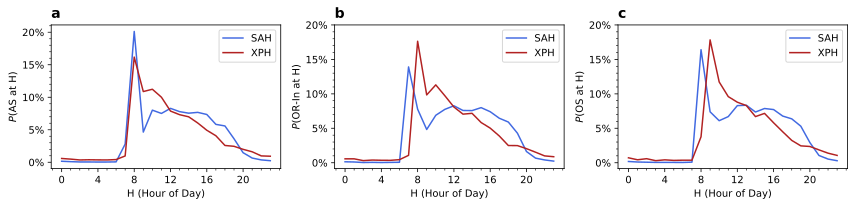

In [97]:
# plot the percentage of 'OR-In', 'AS', 'OS' made at each hour of the day, in a  1*3 subplot grid, with each subplot showing the plot of SAH and XPH data
data1 = sah['data']
data1_idx_to_event = sah['idx_to_event']
data2 = xph['data']
data2_idx_to_event = xph['idx_to_event']

def get_hourly_distribution(data, event_types):
    hourly_counts = {e: {i: 0 for i in range(24)} for e in event_types}
    total_counts = {e: 0 for e in event_types}
    for case in data:
        for event in case['stream']:
            if event['event_type'] in event_types:
                hour = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S').hour
                hourly_counts[event['event_type']][hour] += 1
                total_counts[event['event_type']] += 1
    return {e: {h: hourly_counts[e][h] / total_counts[e] if total_counts[e] > 0 else 0 for h in range(24)} for e in event_types}

sah_event_idx = [1, 3, 4] # 'AS', 'OR-In', 'OS'
xph_event_idx = [1, 0, 2] # 'AS', 'OR-In', 'OS'
hourly_dist1 = get_hourly_distribution(data1, sah_event_idx)
hourly_dist1 = {data1_idx_to_event[k]: v for k,v in hourly_dist1.items()}
hourly_dist2 = get_hourly_distribution(data2, xph_event_idx)
hourly_dist2 = {data2_idx_to_event[k]: v for k,v in hourly_dist2.items()}

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=300)

for i, event_type in enumerate(['AS', 'OR-In', 'OS']):
    ax[i % 3].text(0, 1.05, f'{chr(97+i)}', transform=ax[i % 3].transAxes, fontsize=14, weight='bold')
    if event_type in hourly_dist1:
        ax[i % 3].plot(hourly_dist1[event_type].keys(), hourly_dist1[event_type].values(), label='SAH', color='royalblue')
    if event_type in hourly_dist2:
        ax[i % 3].plot(hourly_dist2[event_type].keys(), hourly_dist2[event_type].values(), label='XPH', color='firebrick')
    ax[i % 3].set_xlabel('H (Hour of Day)')
    ax[i % 3].set_ylabel(f'$P$({event_type} at H)')
    ax[i % 3].legend(loc='upper right')
    ax[i % 3].set_xticks(range(0, 24, 4))
    ax[i % 3].set_yticks(np.arange(0, 0.21, 0.05), [f'{p:.0f}%' for p in np.arange(0, 0.21, 0.05)*100])
    ax[i % 3].minorticks_on()
plt.tight_layout()
plt.savefig('../figures/meso-starttime-distribution.pdf', bbox_inches='tight', dpi=300)
plt.show()

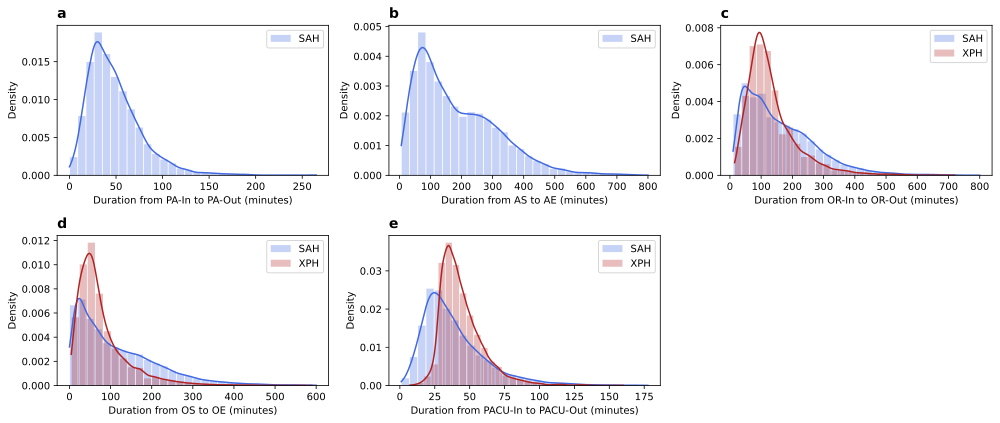

In [ ]:
# plot the duration of histogram and kde of "PA-In" to "PA-Out", "AS" to "AE", "OR-In" to "OR-Out", "OS" to "OE", and "PACU-In" to "PACU-Out" in a 2*3 subplot grid, with each subplot showing the plot of SAH and XPH data
data1 = sah['data']
data1_idx_to_event = sah['idx_to_event']
data2 = xph['data']
data2_idx_to_event = xph['idx_to_event']

def get_durations(data, event_pairs):
    durations = {e: [] for e in event_pairs}
    for case in data:
        timestamps = {event['event_type']: datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S') for event in case['stream']}
        for (start_event, end_event) in event_pairs:
            if start_event in timestamps and end_event in timestamps:
                duration = (timestamps[end_event] - timestamps[start_event]).total_seconds() / 60.0  # duration in minutes
                durations[(start_event, end_event)].append(duration)
    return durations

sah_event_pairs = [(0,2), (1,6), (3,7), (4,5), (8,9)] # ('PA-In', 'PA-Out'), ('AS', 'AE'), ('OR-In', 'OR-Out'), ('OS', 'OE'), ('PACU-In', 'PACU-Out')
xph_event_pairs = [(0,4), (2,3), (5,6)] # ('OR-In', 'OR-Out'), ('OS', 'OE'), ('PACU-In', 'PACU-Out')

sah_durations = get_durations(data1, sah_event_pairs)
sah_durations = {f'{data1_idx_to_event[k[0]]} to {data1_idx_to_event[k[1]]}': v for k,v in sah_durations.items()}

xph_durations = get_durations(data2, xph_event_pairs)
xph_durations = {f'{data2_idx_to_event[k[0]]} to {data2_idx_to_event[k[1]]}': v for k,v in xph_durations.items()}

fig, ax = plt.subplots(2, 3, figsize=(14, 6), dpi=300)
normal_max_value = [300, 800, 800, 600, 180]
for i, event_pair in enumerate([('PA-In', 'PA-Out'), ('AS', 'AE'), ('OR-In', 'OR-Out'), ('OS', 'OE'), ('PACU-In', 'PACU-Out')]):
    ax[i // 3, i % 3].text(0, 1.05, f'{chr(97+i)}', transform=ax[i // 3, i % 3].transAxes, fontsize=14, weight='bold')
    keyi = f'{event_pair[0]} to {event_pair[1]}'
    if keyi in sah_durations:
        sah_dur = [ d for d in sah_durations[keyi] if d <= normal_max_value[i] ]
        sns.histplot(sah_dur, bins=30, kde=True, color='royalblue', edgecolor='none', alpha=0.3, label='SAH', ax=ax[i // 3, i % 3], stat='density', shrink=0.9)
    if keyi in xph_durations:
        xph_dur = [ d for d in xph_durations[keyi] if d <= normal_max_value[i] ]
        sns.histplot(xph_dur, bins=30, kde=True, color='firebrick', edgecolor='none', alpha=0.3, label='XPH', ax=ax[i // 3, i % 3], stat='density', shrink=0.9)
    ax[i // 3, i % 3].set_xlabel(f'Duration from {keyi} (minutes)')
    ax[i // 3, i % 3].set_ylabel(f'Density')
    ax[i // 3, i % 3].legend(loc='upper right')
ax[-1, -1].axis('off')  # Hide the last subplot if not used
plt.tight_layout()
plt.savefig('../figures/meso-duration-distribution.pdf', bbox_inches='tight', dpi=300)
plt.show()

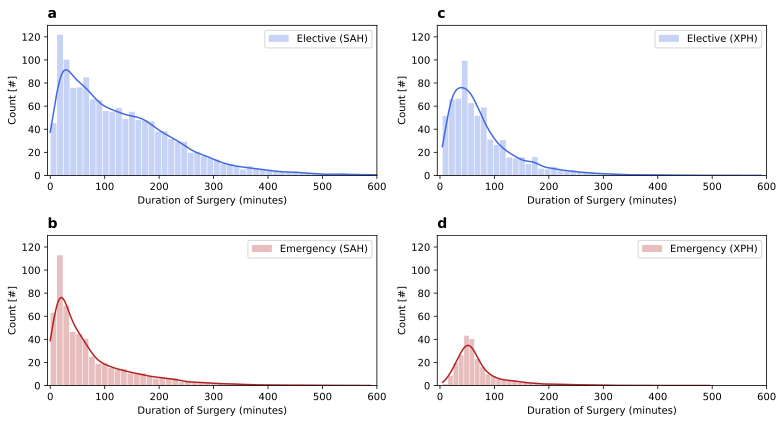

In [34]:
# plot the duration of histogram and KDE of "OS" to "OE" (Length of Operation) for different types of surgeries (elective and emergency) and different hospitals (SAH and XPH) in a 2*2 subplot grid
data1 = sah['data']
data1_idx_to_event = sah['idx_to_event']
data2 = xph['data']
data2_idx_to_event = xph['idx_to_event']

def get_loop(data, start_event, end_event):
    durations = []
    for case in data:
        duration = {'case_idx': case['case_id']}
        for event in case['stream']:
            if event['event_type'] == start_event: start_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
            if event['event_type'] == end_event: end_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
        if 'start_time' in locals() and 'end_time' in locals():
            duration['duration'] = (end_time - start_time).total_seconds() / 60.0 # duration in minutes
            durations.append(duration)
    return pd.DataFrame(durations)

sah_loop = get_loop(data1, 4, 5)  # 'OS' to 'OE'
xph_loop = get_loop(data2, 2, 3)  # 'OS' to 'OE'
# add emergency column to the dataframes from metadata
sah_loop = sah_loop.merge(sah_meta[['case_idx', 'emergency']], on='case_idx', how='left')
xph_loop = xph_loop.merge(xph_meta[['case_idx', 'emergency']], on='case_idx', how='left')

fig, ax = plt.subplots(2, 2, figsize=(11, 6), dpi=300)
for i, (loop_data, hospital_name) in enumerate(zip([sah_loop, xph_loop], ['SAH', 'XPH'])):
    for j, emergency in enumerate(['0', '1']):  # '0' for elective, '1' for emergency
        ax[j, i].text(0, 1.05, f'{chr(97+i*2+j)}', transform=ax[j, i].transAxes, fontsize=14, weight='bold')
        loop_data_emergency = loop_data[loop_data['emergency'] == emergency]['duration'].tolist()
        loop_data_emergency = [d for d in loop_data_emergency if d <= 600]  # filter out durations longer than 600 minutes (10 hours)
        label = f'{"Elective" if emergency == "0" else "Emergency"} ({hospital_name})'
        sns.histplot(loop_data_emergency, bins=50, kde=True, color='royalblue' if emergency == '0' else 'firebrick', edgecolor='none', alpha=0.3, ax=ax[j, i], stat='frequency', shrink=0.9, label=label)
        ax[j, i].set_xlabel(f"Duration of Surgery (minutes)")
        ax[j, i].set_ylabel('Count [#]')
        ax[j, i].set_xlim([-5, 600])
        ax[j, i].set_ylim([0, 130])
        ax[j, i].legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/meso-loop-duration-distribution.pdf', bbox_inches='tight', dpi=300)
plt.show()

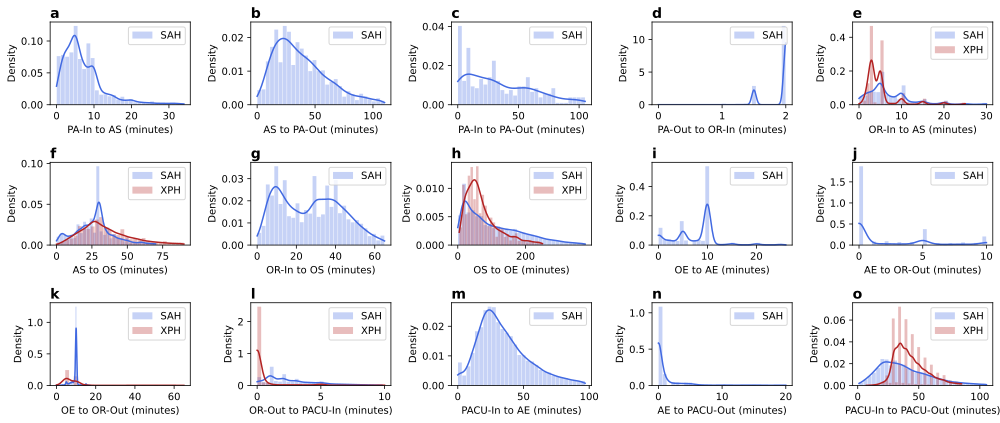

In [ ]:
# plot the inter-event time (consecutive events) distribution
data1 = sah['data']
data1_idx_to_event = sah['idx_to_event']
data2 = xph['data']
data2_idx_to_event = xph['idx_to_event']

def get_inter_event_time(data):
    durations = {}
    for case in data:
        for i in range(len(case['stream']) - 1):
            start_event = case['stream'][i]['event_type']
            end_event = case['stream'][i+1]['event_type']
            if (start_event, end_event) not in durations:
                durations[(start_event, end_event)] = []
            start_time = datetime.strptime(case['stream'][i]['timestamp'], '%Y-%m-%d %H:%M:%S')
            end_time = datetime.strptime(case['stream'][i+1]['timestamp'], '%Y-%m-%d %H:%M:%S')
            duration = (end_time - start_time).total_seconds() / 60.0
            durations[(start_event, end_event)].append(duration)
    return durations

sah_iet = get_inter_event_time(data1)
sah_iet = {f'{data1_idx_to_event[k[0]]} to {data1_idx_to_event[k[1]]}': v for k,v in sah_iet.items()}
xph_iet = get_inter_event_time(data2)
xph_iet = {f'{data2_idx_to_event[k[0]]} to {data2_idx_to_event[k[1]]}': v for k,v in xph_iet.items()}

# {'0': 'PA-In','1': 'AS','2': 'PA-Out','3': 'OR-In','4': 'OS','5': 'OE','6': 'AE','7': 'OR-Out','8': 'PACU-In','9': 'PACU-Out'}
available_pairs = [('PA-In', 'AS'), ('AS', 'PA-Out'), ('PA-In', 'PA-Out'), ('PA-Out', 'OR-In'), ('OR-In', 'AS'), ('AS', 'OS'), ('OR-In', 'OS'), ('OS', 'OE'), ('OE', 'AE'), ('AE', 'OR-Out'), ('OE', 'OR-Out'), ('OR-Out', 'PACU-In'), ('PACU-In', 'AE'), ('AE', 'PACU-Out'), ('PACU-In', 'PACU-Out')]

fig, ax = plt.subplots(3, 5, figsize=(14, 6), dpi=300)

for i, (start_event, end_event) in enumerate(available_pairs):
    ax[i // 5, i % 5].text(0, 1.05, f'{chr(97+i)}', transform=ax[i // 5, i % 5].transAxes, fontsize=14, weight='bold')
    keyi = f'{start_event} to {end_event}'
    if keyi in sah_iet:
        # remove extreme outliers above 97.5 quantiles of the data
        quantile975 = np.quantile(sah_iet[keyi], 0.975)
        iet_data = [d for d in sah_iet[keyi] if d <= quantile975]
        sns.histplot(iet_data, bins=30, kde=True, color='royalblue', edgecolor='none', alpha=0.3, label='SAH', ax=ax[i // 5, i % 5], stat='density', shrink=0.9)
    if keyi in xph_iet:
        quantile975 = np.quantile(xph_iet[keyi], 0.975)
        iet_data = [d for d in xph_iet[keyi] if d <= quantile975]
        sns.histplot(iet_data, bins=30, kde=True, color='firebrick', edgecolor='none', alpha=0.3, label='XPH', ax=ax[i // 5, i % 5], stat='density', shrink=0.9)
    ax[i // 5, i % 5].set_xlabel(f'{start_event} to {end_event} (minutes)')
    ax[i // 5, i % 5].set_ylabel('Density')
    ax[i // 5, i % 5].legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/meso-inter-event-time-distribution.pdf', bbox_inches='tight', dpi=300)
plt.show()

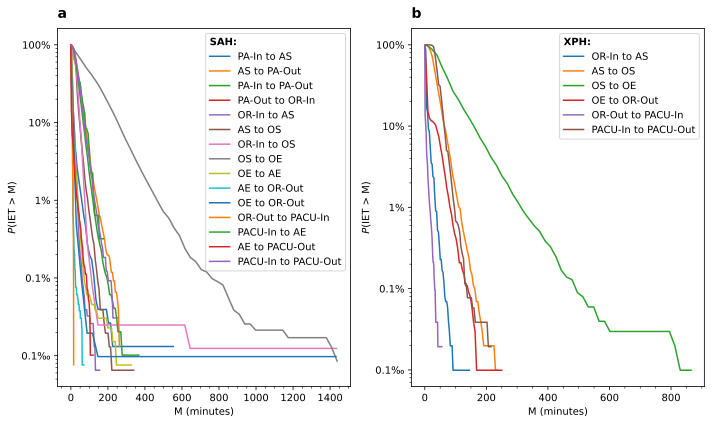

In [ ]:
# plot the inter-event time (consecutive events) complementary cumulative distribution function in a 1 * 2 subplot grid for SAH and XPH data
data1 = sah['data']
data1_idx_to_event = sah['idx_to_event']
data2 = xph['data']
data2_idx_to_event = xph['idx_to_event']

def get_inter_event_time(data):
    durations = {}
    for case in data:
        for i in range(len(case['stream']) - 1):
            start_event = case['stream'][i]['event_type']
            end_event = case['stream'][i+1]['event_type']
            if (start_event, end_event) not in durations:
                durations[(start_event, end_event)] = []
            start_time = datetime.strptime(case['stream'][i]['timestamp'], '%Y-%m-%d %H:%M:%S')
            end_time = datetime.strptime(case['stream'][i+1]['timestamp'], '%Y-%m-%d %H:%M:%S')
            duration = (end_time - start_time).total_seconds() / 60.0
            durations[(start_event, end_event)].append(duration)
    return durations

sah_iet = get_inter_event_time(data1)
sah_iet = {f'{data1_idx_to_event[k[0]]} to {data1_idx_to_event[k[1]]}': v for k,v in sah_iet.items()}
xph_iet = get_inter_event_time(data2)
xph_iet = {f'{data2_idx_to_event[k[0]]} to {data2_idx_to_event[k[1]]}': v for k,v in xph_iet.items()}

# {'0': 'PA-In','1': 'AS','2': 'PA-Out','3': 'OR-In','4': 'OS','5': 'OE','6': 'AE','7': 'OR-Out','8': 'PACU-In','9': 'PACU-Out'}
available_pairs = [('PA-In', 'AS'), ('AS', 'PA-Out'), ('PA-In', 'PA-Out'), ('PA-Out', 'OR-In'), ('OR-In', 'AS'), ('AS', 'OS'), ('OR-In', 'OS'), ('OS', 'OE'), ('OE', 'AE'), ('AE', 'OR-Out'), ('OE', 'OR-Out'), ('OR-Out', 'PACU-In'), ('PACU-In', 'AE'), ('AE', 'PACU-Out'), ('PACU-In', 'PACU-Out')]

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=300)
cont_ccdf = lambda x_l, arr: [(x_l >= val).sum() / len(x_l) for val in arr]

for i, (start_event, end_event) in enumerate(available_pairs):
    for j in range(2):
        keyi = f'{start_event} to {end_event}'
        if j == 0 and keyi in sah_iet:
            arr_iet = np.linspace(min(sah_iet[keyi]), max(sah_iet[keyi]), num=50)
            ccdf_iet = cont_ccdf(sah_iet[keyi], arr_iet)
            ax[j].plot(arr_iet, ccdf_iet, label=keyi)
        if j == 1 and keyi in xph_iet:
            arr_iet = np.linspace(min(xph_iet[keyi]), max(xph_iet[keyi]), num=50)
            ccdf_iet = cont_ccdf(xph_iet[keyi], arr_iet)
            ax[j].plot(arr_iet, ccdf_iet, label=keyi)
        
        
for j in range(2):
    ax[j].text(0, 1.03, f'{chr(97+j)}', transform=ax[j].transAxes, fontsize=14, weight='bold')
    ax[j].set_xlabel('M (minutes)')
    ax[j].set_ylabel('$P$(IET > M)')
    ax[j].set_yscale("log")
    ax[j].set_yticks([1e-4,1e-3, 1e-2,1e-1,1e0])
    ax[j].set_yticklabels(["0.1‰","0.1%", "1%", "10%", "100%"])
    ax[j].minorticks_on()
    ax[j].legend(title='SAH:' if j == 0 else 'XPH:', alignment='left', title_fontproperties={'weight': 'bold'}, loc='upper right')

plt.tight_layout()
plt.savefig('../figures/meso-inter-event-time-ccdf.pdf', bbox_inches='tight', dpi=300)
plt.show()

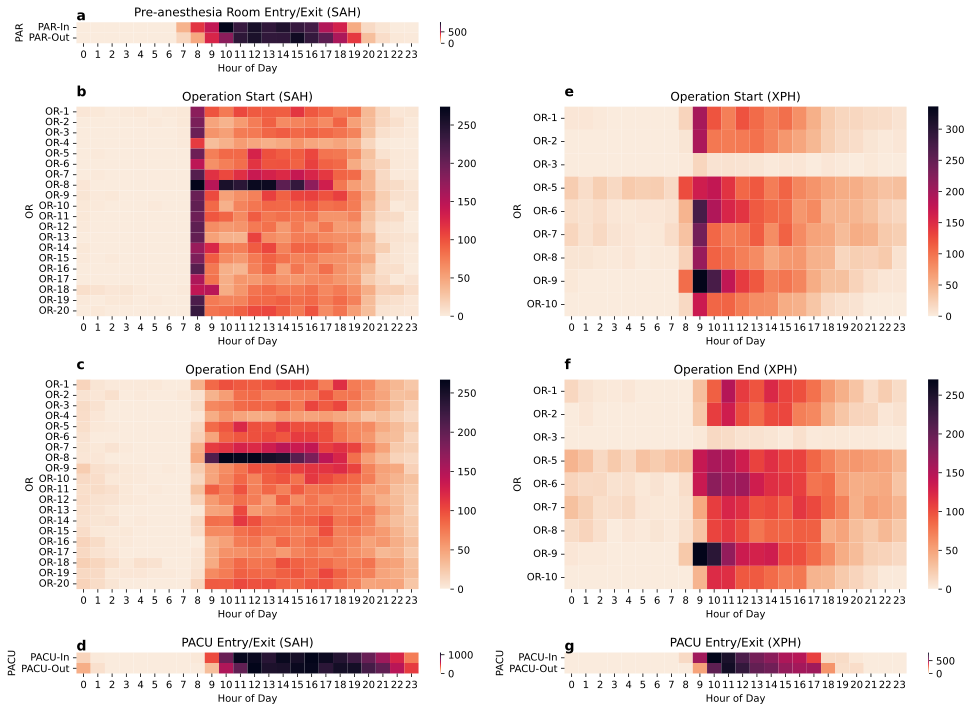

In [ ]:
# plot the heatmap of the operation start time, operation end time, pacu-in time, and pacu-out time for each operating room and time of day (hour of day) for SAH and XPH data in a 2 * 2 subplot grid
# for each plot, x-axis: operating room (include PACU), y-axis: hour of day, color: event time rate (operation start, operation end, pacu-in, pacu-out)
data1 = sah['data']
sah_idx_to_event = sah['idx_to_event']
sah_idx_to_room = sah['idx_to_room']
data2 = xph['data']
xph_idx_to_event = xph['idx_to_event']
xph_idx_to_room = xph['idx_to_room']

def get_heatmap_data(data, idx_to_room, idx_to_event, start_event='OS', end_event='OE'):
    heatmap_data_start = {room: {hour: 0 for hour in range(24)} for room in idx_to_room.values()}
    heatmap_data_end = {room: {hour: 0 for hour in range(24)} for room in idx_to_room.values()}
    for case in data:
        for event in case['stream']:
            if idx_to_event[event['event_type']] == start_event: # Operation Start or PACU In
                room = idx_to_room[event['event_loc']]
                hour = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S').hour
                heatmap_data_start[room][hour] += 1
            elif idx_to_event[event['event_type']] == end_event: # Operation End or PACU Out
                room = idx_to_room[event['event_loc']]
                hour = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S').hour
                heatmap_data_end[room][hour] += 1
    return heatmap_data_start, heatmap_data_end


sah_par_room = {k: v for k, v in sah_idx_to_room.items() if 'PAR' in v}
sah_heatmap_pai, sah_heatmap_pao = get_heatmap_data(data1, sah_par_room, sah_idx_to_event, 'PA-In', 'PA-Out')
sah_heatmap_pa = {'PAR-In': sah_heatmap_pai['PAR'], 'PAR-Out': sah_heatmap_pao['PAR']}
sah_or_room = {k: v for k, v in sah_idx_to_room.items() if 'OR' in v}
sah_heatmap_os, sah_heatmap_oe = get_heatmap_data(data1, sah_or_room, sah_idx_to_event, 'OS', 'OE')
sah_pacu_room = {k: v for k, v in sah_idx_to_room.items() if 'PACU' in v}
sah_heatmap_pacui, sah_heatmap_pacuo = get_heatmap_data(data1, sah_pacu_room, sah_idx_to_event, 'PACU-In', 'PACU-Out')
sah_heatmap_pacu = {'PACU-In': sah_heatmap_pacui['PACU'], 'PACU-Out': sah_heatmap_pacuo['PACU']}

xph_or_room = {k: v for k, v in xph_idx_to_room.items() if 'OR' in v}
xph_heatmap_os, xph_heatmap_oe = get_heatmap_data(data2, xph_or_room, xph_idx_to_event, 'OS', 'OE')
xph_pacu_room = {k: v for k, v in xph_idx_to_room.items() if 'PACU' in v}
xph_heatmap_pacui, xph_heatmap_pacuo = get_heatmap_data(data2, xph_pacu_room, xph_idx_to_event, 'PACU-In', 'PACU-Out')
xph_heatmap_pacu = {'PACU-In': xph_heatmap_pacui['PACU'], 'PACU-Out': xph_heatmap_pacuo['PACU']}

fig = plt.figure(figsize=(14, 10), dpi=300)
gs = GridSpec(4, 2, figure=fig, height_ratios=[2, 20, 20, 2])
ax = [[], [], [], []]
ax[0].append(fig.add_subplot(gs[0, 0]))  # First row, first column
ax[1].append(fig.add_subplot(gs[1, 0]))  # Second row, first column
ax[1].append(fig.add_subplot(gs[1, 1]))  # Second row, second column
ax[2].append(fig.add_subplot(gs[2, 0]))  # Third row, first column
ax[2].append(fig.add_subplot(gs[2, 1]))  # Third row, second column
ax[3].append(fig.add_subplot(gs[3, 0]))  # Fourth row, first column
ax[3].append(fig.add_subplot(gs[3, 1]))  # Fourth row, second column


sns.heatmap(pd.DataFrame(sah_heatmap_pa).T, ax=ax[0][0], cmap='rocket_r', fmt='d')
ax[0][0].set_xlabel('Hour of Day')
ax[0][0].set_ylabel('PAR')
ax[0][0].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[0][0].set_yticks([r + 0.5 for r in range(len(sah_heatmap_pa))], list(sah_heatmap_pa.keys()), rotation=0)
ax[0][0].text(0, 1.1, 'a', transform=ax[0][0].transAxes, fontsize=14, weight='bold')
ax[0][0].set_title('Pre-anesthesia Room Entry/Exit (SAH)')
sns.heatmap(pd.DataFrame(sah_heatmap_os).T, ax=ax[1][0], cmap='rocket_r', fmt='d')
ax[1][0].set_xlabel('Hour of Day')
ax[1][0].set_ylabel('OR')
ax[1][0].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[1][0].set_yticks([r + 0.5 for r in range(len(sah_or_room))], list(sah_or_room.values()))
ax[1][0].text(0, 1.05, 'b', transform=ax[1][0].transAxes, fontsize=14, weight='bold')
ax[1][0].set_title('Operation Start (SAH)')
sns.heatmap(pd.DataFrame(sah_heatmap_oe).T, ax=ax[2][0], cmap='rocket_r', fmt='d')
ax[2][0].set_xlabel('Hour of Day')
ax[2][0].set_ylabel('OR')
ax[2][0].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[2][0].set_yticks([r + 0.5 for r in range(len(sah_or_room))], list(sah_or_room.values()))
ax[2][0].text(0, 1.05, 'c', transform=ax[2][0].transAxes, fontsize=14, weight='bold')
ax[2][0].set_title('Operation End (SAH)')
sns.heatmap(pd.DataFrame(sah_heatmap_pacu).T, ax=ax[3][0], cmap='rocket_r', fmt='d')
ax[3][0].set_xlabel('Hour of Day')
ax[3][0].set_ylabel('PACU')
ax[3][0].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[3][0].set_yticks([r + 0.5 for r in range(len(sah_heatmap_pacu))], list(sah_heatmap_pacu.keys()), rotation=0)
ax[3][0].text(0, 1.1, 'd', transform=ax[3][0].transAxes, fontsize=14, weight='bold')
ax[3][0].set_title('PACU Entry/Exit (SAH)')

# ax[0, 1].axis('off')  # Hide the first subplot in the second column
sns.heatmap(pd.DataFrame(xph_heatmap_os).T, ax=ax[1][1], cmap='rocket_r', fmt='d')
ax[1][1].set_xlabel('Hour of Day')
ax[1][1].set_ylabel('OR')
ax[1][1].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[1][1].set_yticks([r + 0.5 for r in range(len(xph_or_room))], list(xph_or_room.values()))
ax[1][1].text(0, 1.05, 'e', transform=ax[1][1].transAxes, fontsize=14, weight='bold')
ax[1][1].set_title('Operation Start (XPH)')
sns.heatmap(pd.DataFrame(xph_heatmap_oe).T, ax=ax[2][1], cmap='rocket_r', fmt='d')
ax[2][1].set_xlabel('Hour of Day')
ax[2][1].set_ylabel('OR')
ax[2][1].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[2][1].set_yticks([r + 0.5 for r in range(len(xph_or_room))], list(xph_or_room.values()))
ax[2][1].text(0, 1.05, 'f', transform=ax[2][1].transAxes, fontsize=14, weight='bold')
ax[2][1].set_title('Operation End (XPH)')
sns.heatmap(pd.DataFrame(xph_heatmap_pacu).T, ax=ax[3][1], cmap='rocket_r', fmt='d')
ax[3][1].set_xlabel('Hour of Day')
ax[3][1].set_ylabel('PACU')
ax[3][1].set_xticks([h + 0.5 for h in range(24)], [f'{h}' for h in range(24)], rotation=0)
ax[3][1].set_yticks([r + 0.5 for r in range(len(xph_heatmap_pacu))], list(xph_heatmap_pacu.keys()), rotation=0)
ax[3][1].text(0, 1.1, 'g', transform=ax[3][1].transAxes, fontsize=14, weight='bold')
ax[3][1].set_title('PACU Entry/Exit (XPH)')

plt.tight_layout()
plt.savefig('../figures/meso-heatmap-start-end-time.pdf', bbox_inches='tight', dpi=300)
plt.show()

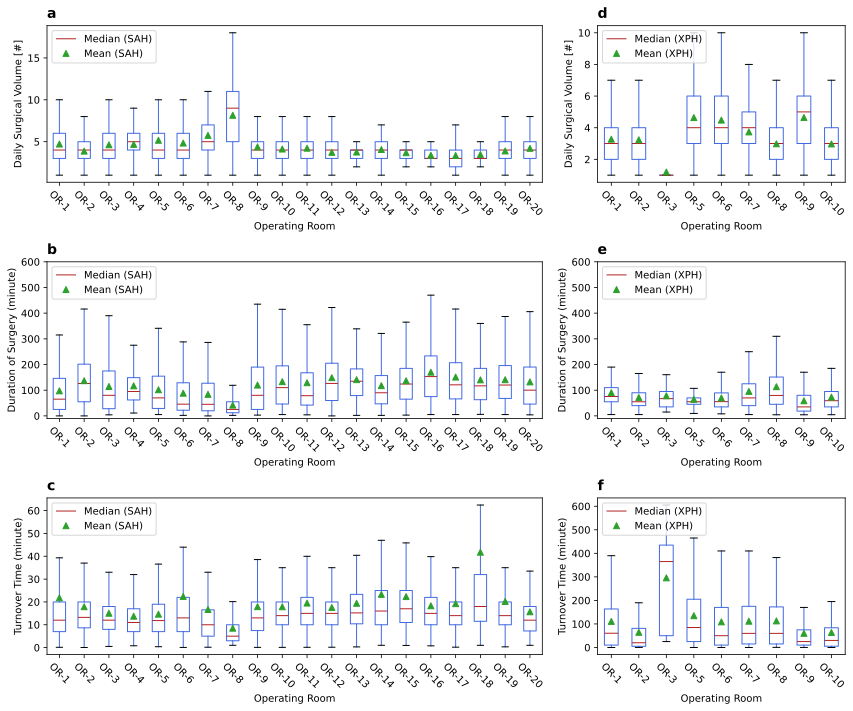

In [25]:
# box plots of number of surgeries per day, LOOP duration, and turnover time across different operating rooms for SAH and XPH data, in a 3*2 subplot grid
data1 = sah['data']
sah_idx_to_event = sah['idx_to_event']
sah_idx_to_room = sah['idx_to_room']
data2 = xph['data']
xph_idx_to_event = xph['idx_to_event']
xph_idx_to_room = xph['idx_to_room']

def get_surgeries_per_day(data, idx_to_room, idx_to_event):
    surgeries_per_day = {room: [] for room in idx_to_room.values()}
    for case in data:
        date = datetime.strptime(case['event_date'], '%Y-%m-%d').date()
        for event in case['stream']:
            if idx_to_event[event['event_type']] == 'OS':  # Operation Start
                room = idx_to_room[event['event_loc']]
                surgeries_per_day[room].append(date)
                break
    return {room: Counter(dates).values() for room, dates in surgeries_per_day.items()}


def get_loop_duration(data, idx_to_room, idx_to_event, start_event='OS', end_event='OE'):
    loop_durations = {room: [] for room in idx_to_room.values()}
    for case in data:
        for event in case['stream']:
            if idx_to_event[event['event_type']] == start_event:  # Operation Start
                room = idx_to_room[event['event_loc']]
                start_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
            if idx_to_event[event['event_type']] == end_event: # Operation End
                end_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
                break
        if 'start_time' in locals() and 'end_time' in locals():
            duration = (end_time - start_time).total_seconds() / 60.0  # duration in minutes
            loop_durations[room].append(duration)
    return loop_durations

def get_turnover_time(data, idx_to_room, idx_to_event, start_event='OR-In', end_event='OR-Out'):
    turnovers = {room: {} for room in idx_to_room.values()}
    for case in data:
        date = datetime.strptime(case['event_date'], '%Y-%m-%d').date()
        for event in case['stream']:
            if idx_to_event[event['event_type']] == start_event:
                room = idx_to_room[event['event_loc']]
                start_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
            if idx_to_event[event['event_type']] == end_event:
                end_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
                break
        if 'start_time' in locals() and 'end_time' in locals():
            if date not in turnovers[room]: turnovers[room][date] = []
            turnovers[room][date].append((start_time, end_time))
    turnover_times = {room: [] for room in idx_to_room.values()}
    for room, ts in turnovers.items():
        for date, times in ts.items():
            if len(times) > 1:
                times_sort = sorted(times, key=lambda x: x[0])  # sort by start time
                for i in range(len(times_sort) - 1):
                    duration = (times_sort[i + 1][0] - times_sort[i][1]).total_seconds() / 60.0
                    if duration > 0:
                        turnover_times[room].append(duration)
    return turnover_times

sah_or_room = {k: v for k, v in sah_idx_to_room.items() if 'OR' in v}
sah_surgeries_per_day = get_surgeries_per_day(data1, sah_or_room, sah_idx_to_event)
sah_loop_duration = get_loop_duration(data1, sah_or_room, sah_idx_to_event, 'OS', 'OE')
sah_turnover_time = get_turnover_time(data1, sah_or_room, sah_idx_to_event, 'OR-In', 'OR-Out')
xph_or_room = {k: v for k, v in xph_idx_to_room.items() if 'OR' in v}
xph_surgeries_per_day = get_surgeries_per_day(data2, xph_or_room, xph_idx_to_event)
xph_loop_duration = get_loop_duration(data2, xph_or_room, xph_idx_to_event, 'OS', 'OE')
xph_turnover_time = get_turnover_time(data2, xph_or_room, xph_idx_to_event, 'OR-In', 'OR-Out')

fig = plt.figure(figsize=(12, 10), dpi=300)
gs = GridSpec(3, 2, figure=fig, width_ratios=[20, 10])
ax = [[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
      [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],
      [fig.add_subplot(gs[2, 0]), fig.add_subplot(gs[2, 1])]]
# Plot surgeries per day
sah_surgeries_df = pd.DataFrame.from_dict(sah_surgeries_per_day, orient='index').T
xph_surgeries_df = pd.DataFrame.from_dict(xph_surgeries_per_day, orient='index').T
bp1 = sah_surgeries_df.boxplot(ax=ax[0][0], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
bp2 = xph_surgeries_df.boxplot(ax=ax[0][1], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
ax[0][0].set_ylabel('Daily Surgical Volume [#]')
ax[0][1].set_ylabel('Daily Surgical Volume [#]')
ax[0][0].set_xlabel('Operating Room')
ax[0][1].set_xlabel('Operating Room')
ax[0][0].legend([bp1['medians'][0], bp1['means'][0]], ['Median (SAH)', 'Mean (SAH)'], loc='upper left')
ax[0][1].legend([bp2['medians'][0], bp2['means'][0]], ['Median (XPH)', 'Mean (XPH)'], loc='upper left')

# Plot loop duration
sah_loop_df = pd.DataFrame.from_dict(sah_loop_duration, orient='index').T
xph_loop_df = pd.DataFrame.from_dict(xph_loop_duration, orient='index').T
bp1 = sah_loop_df.boxplot(ax=ax[1][0], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
bp2 = xph_loop_df.boxplot(ax=ax[1][1], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
ax[1][0].set_ylabel('Duration of Surgery (minute)')
ax[1][1].set_ylabel('Duration of Surgery (minute)')
ax[1][0].set_xlabel('Operating Room')
ax[1][1].set_xlabel('Operating Room')
ax[1][0].set_ylim([-10, 600])
ax[1][1].set_ylim([-10, 600])
ax[1][0].legend([bp1['medians'][0], bp1['means'][0]], ['Median (SAH)', 'Mean (SAH)'], loc='upper left')
ax[1][1].legend([bp2['medians'][0], bp2['means'][0]], ['Median (XPH)', 'Mean (XPH)'], loc='upper left')

# Plot turnover time
sah_turnover_df = pd.DataFrame.from_dict(sah_turnover_time, orient='index').T
xph_turnover_df = pd.DataFrame.from_dict(xph_turnover_time, orient='index').T
bp1 = sah_turnover_df.boxplot(ax=ax[2][0], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
bp2 = xph_turnover_df.boxplot(ax=ax[2][1], grid=False, rot=-45, boxprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'), flierprops=dict(markersize=4), medianprops=dict(color='firebrick'), showfliers=False, showmeans=True, return_type='dict')
ax[2][0].set_ylabel('Turnover Time (minute)')
ax[2][1].set_ylabel('Turnover Time (minute)')
ax[2][0].set_xlabel('Operating Room')
ax[2][1].set_xlabel('Operating Room') 
ax[2][0].legend([bp1['medians'][0], bp1['means'][0]], ['Median (SAH)', 'Mean (SAH)'], loc='upper left')
ax[2][1].legend([bp2['medians'][0], bp2['means'][0]], ['Median (XPH)', 'Mean (XPH)'], loc='upper left')

# plot labels
for i in range(2):
    for j in range(3):
        ax[j][i].text(0, 1.05, f'{chr(97+i*3+j)}', transform=ax[j][i].transAxes, fontsize=14, weight='bold')


plt.tight_layout()
plt.savefig('../figures/meso-room-diversity-boxplot.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# fit a XGBoost regression model to the metadata vs DOS for SAH and XPH, and plot the SHAP graph in a 2*2 subplot grid
data1 = sah['data']
sah_idx_to_event = sah['idx_to_event']
data2 = xph['data']
xph_idx_to_event = xph['idx_to_event']

def get_loop(data, start_event, end_event):
    durations = []
    for case in data:
        duration = {'case_idx': case['case_id']}
        for event in case['stream']:
            if event['event_type'] == start_event: 
                start_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
                num_operator = len(event['surgeon'])
                surgeon = event['surgeon'][0] if num_operator > 0 else np.nan
                num_anesthetist = len(event['anesthetist'])
                num_nurse = len(event['nurse'])
            if event['event_type'] == end_event: end_time = datetime.strptime(event['timestamp'], '%Y-%m-%d %H:%M:%S')
        if 'start_time' in locals() and 'end_time' in locals():
            duration['duration'] = (end_time - start_time).total_seconds() / 60.0 # duration in minutes
            duration['num_operator'] = num_operator
            duration['surgeon'] = surgeon
            duration['num_anesthetist'] = num_anesthetist
            duration['num_nurse'] = num_nurse
            durations.append(duration)
    return pd.DataFrame(durations)


sah_loop = get_loop(data1, 4, 5)  # 'OS' to 'OE'
xph_loop = get_loop(data2, 2, 3)  # 'OS' to 'OE'
# add metadata column to the dataframes from metadata
sah_loop = sah_loop.merge(sah_meta, on='case_idx', how='left')
xph_loop = xph_loop.merge(xph_meta, on='case_idx', how='left')

sah_loop['diagnosis_ICD10_trunc'] = sah_loop['diagnosis_ICD10'].apply(lambda x: x.split('.')[0] if pd.notna(x) else np.nan)
sah_loop['main_procedure_ICD9_trunc'] = sah_loop['main_procedure_ICD9'].apply(lambda x: x[:4] if pd.notna(x) else np.nan)
sah_loop['height'] = sah_loop['height'].replace(0, np.nan)  # replace 0 with NaN for height
sah_loop['weight'] = sah_loop['weight'].replace(0, np.nan)  # replace 0 with NaN for weight

xph_loop['diagnosis_ICD10_trunc'] = xph_loop['diagnosis_ICD10'].apply(lambda x: x.split('.')[0] if pd.notna(x) else np.nan)
xph_loop['main_procedure_ICD9_trunc'] = xph_loop['main_procedure_ICD9'].apply(lambda x: x[:4] if pd.notna(x) else np.nan)
xph_loop['height'] = xph_loop['height'].replace(0, np.nan)  # replace 0 with NaN for height
xph_loop['weight'] = xph_loop['weight'].replace(0, np.nan)  # replace 0 with NaN for weight

print(sah_loop.shape)
print(xph_loop.shape)
sah_loop.head()

(23456, 19)
(10096, 19)


case_idx  duration  num_operator  \
0  90b82ee0-01ca-4e18-9746-46f10252052b      20.0             2   
1  4dca56fd-27ec-495a-a200-056526e3c642     205.0             2   
2  24c490ee-b956-4af9-8a41-a26a60eeeec2     215.0             2   
3  a452aed8-ee9a-4606-8c68-09b9950148b1     175.0             3   
4  38a3979c-e22d-4932-acfc-a6c40a8e28c3      64.0             2   

                                surgeon  num_anesthetist  num_nurse sex  age  \
0  571954e6-5f0d-4d55-a2ce-2ea6805a425b                2          1   1   60   
1  4b99d08f-a15c-4491-ba2b-cd7649403da9                2          2   1   29   
2  85c68219-5290-471d-9454-55aef3161523                2          2   1   57   
3  1e8d774e-9f43-42a0-b1fb-c8f25007a902                2          2   1   59   
4  88ef4728-4232-4fcb-b277-a129463b646a                2          2   0   50   

   height  weight diagnosis_ICD10 op_level emergency main_procedure_ICD9  \
0   162.0    70.0         K60.303        2         0             49.7301   
1   171.0    66.0         C20.x00        4         0             48.6302   
2   172.0    55.0         C20.x00        4         0             48.6302   
3   173.0    68.0         C18.600        4         0         17.3900x002   
4   160.0    58.0         Z43.200        2         0             46.5101   

                        exec_department anesthesia_method asa_level  \
0  b67de430-978e-459f-a599-9d825c8fc802                 8         2   
1  5f75ad41-1a86-41ab-9846-d1bc95134486                 1         1   
2  fd3b929b-7c70-4ea2-9faf-1b3009cd93e9                 1         2   
3  4712944a-131c-4936-a2b9-29de5dcf7b13                 1         2   
4  fd3b929b-7c70-4ea2-9faf-1b3009cd93e9                 7         2   

  diagnosis_ICD10_trunc main_procedure_ICD9_trunc  
0                   K60                      49.7  
1                   C20                      48.6  
2                   C20                      48.6  
3                   C18                      17.3  
4                   Z43                      46.5

In [40]:
X_sah = sah_loop.drop(columns=['case_idx', 'duration', 'diagnosis_ICD10', 'main_procedure_ICD9'], axis=1)
X_sah['surgeon'] = X_sah['surgeon'].astype('category').cat.codes
X_sah['sex'] = X_sah['sex'].astype('category')
X_sah['op_level'] = X_sah['op_level'].astype('category')
X_sah['emergency'] = X_sah['emergency'].astype('category')
X_sah['exec_department'] = X_sah['exec_department'].astype('category').cat.codes
X_sah['anesthesia_method'] = X_sah['anesthesia_method'].astype('category')
X_sah['asa_level'] = X_sah['asa_level'].astype('category')
X_sah.rename(columns={
    'diagnosis_ICD10_trunc': 'diagnosis_ICD10',
    'main_procedure_ICD9_trunc': 'main_procedure_ICD9'
}, inplace=True)
X_sah['diagnosis_ICD10'] = X_sah['diagnosis_ICD10'].astype('category')
X_sah['main_procedure_ICD9'] = X_sah['main_procedure_ICD9'].astype('category')

y_sah = sah_loop['duration']

X_train, X_test, y_train, y_test = train_test_split(X_sah, y_sah, test_size=0.2, random_state=42)

model_sah = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)
model_sah.fit(X_train, y_train)

explainer_sah = shap.TreeExplainer(model_sah)
shap_sah = explainer_sah(X_test)

In [41]:
X_xph = xph_loop.drop(columns=['case_idx', 'duration', 'diagnosis_ICD10', 'main_procedure_ICD9'], axis=1)
X_xph['surgeon'] = X_xph['surgeon'].astype('category').cat.codes
X_xph['sex'] = X_xph['sex'].astype('category')
X_xph['op_level'] = X_xph['op_level'].astype('category')
X_xph['emergency'] = X_xph['emergency'].astype('category')
X_xph['exec_department'] = X_xph['exec_department'].astype('category').cat.codes
X_xph['anesthesia_method'] = X_xph['anesthesia_method'].astype('category')
X_xph['asa_level'] = X_xph['asa_level'].astype('category')
X_xph.rename(columns={
    'diagnosis_ICD10_trunc': 'diagnosis_ICD10',
    'main_procedure_ICD9_trunc': 'main_procedure_ICD9'
}, inplace=True)
X_xph['diagnosis_ICD10'] = X_xph['diagnosis_ICD10'].astype('category')
X_xph['main_procedure_ICD9'] = X_xph['main_procedure_ICD9'].astype('category')
y_xph = xph_loop['duration']

X_train, X_test, y_train, y_test = train_test_split(X_xph, y_xph, test_size=0.2, random_state=42)
model_xph = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)
model_xph.fit(X_train, y_train)

explainer_xph = shap.TreeExplainer(model_xph)
shap_xph = explainer_xph(X_test)

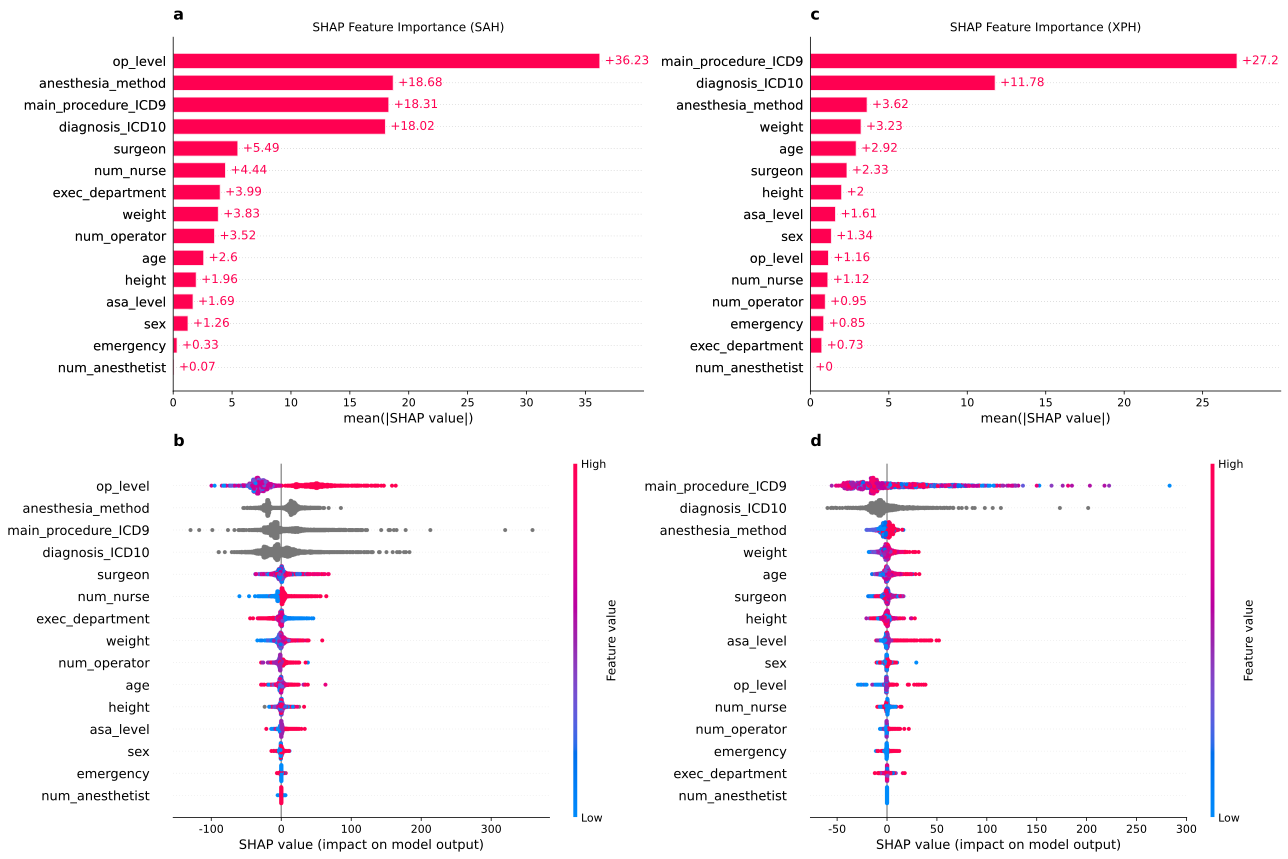

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12), dpi=300)
for i in range(2):
    for j in range(2):
        ax[j, i].text(0, 1.05, f'{chr(97+i*2+j)}', transform=ax[j, i].transAxes, fontsize=16, fontweight='bold')
        if j == 0: ax[j, i].set_title(f'SHAP Feature Importance ({'SAH' if i == 0 else 'XPH'})')
shap.plots.bar(shap_sah, max_display=20, ax=ax[0, 0], show=False)
shap.plots.beeswarm(shap_sah, ax=ax[1, 0], plot_size=None, show=False, axis_color='black', max_display=20)

shap.plots.bar(shap_xph, max_display=20, ax=ax[0, 1], show=False)
shap.plots.beeswarm(shap_xph, ax=ax[1, 1], plot_size=None, show=False, axis_color='black', max_display=20)

plt.tight_layout()
plt.savefig('../figures/meso-shap-importance.pdf', dpi=300, bbox_inches='tight')
plt.show()